### Sentiment Analysis Python

Natural Language Processing Python Project creating a Sentiment Analysis classifier using 3 different techniques:

        K-nn (K-nearest neighbors)
        VADER (Valence Aware Dictionary and sEntiment Reasoner)
        Logistic Regression model


#### About Dataset


This dataset consists of thousands of Amazon customer reviews (Text) and star ratings (Score) for learning how to train model for sentiment analysis.

### Step 0. Read in Data and analyses

In [1]:
import pandas as pd                     # pip install pandas
import re                               # for regex
import nltk                             # pip install nltk
import matplotlib.pyplot as plt         # pip install matplotlib

from nltk.corpus import stopwords                                       # pip install nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer             # Vader Sentiment Analysis (eng)
from sklearn.feature_extraction.text import CountVectorizer             # pip install scikit-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# Read in data
df = pd.read_csv('Reviews.csv')

In [3]:
# Attribute information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           5000 non-null   int64 
 1   ProductId    5000 non-null   object
 2   ProfileName  5000 non-null   object
 3   Score        5000 non-null   int64 
 4   Text         5000 non-null   object
dtypes: int64(2), object(3)
memory usage: 195.4+ KB


In [4]:
# Show the first 5 data of the file
df.head()

,Id,ProductId,ProfileName,Score,Text
0,1,B001E4KFG0,delmartian,5,I have bought several of the Vitality canned d...
1,2,B00813GRG4,dll pa,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,"Natalia Corres ""Natalia Corres""",4,This is a confection that has been around a fe...
3,4,B000UA0QIQ,Karl,2,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,"Michael D. Bigham ""M. Wassir""",5,Great taffy at a great price. There was a wid...


- Data analysis

1     469
2     290
3     395
4     712
5    3134
Name: Score, dtype: int64


[]

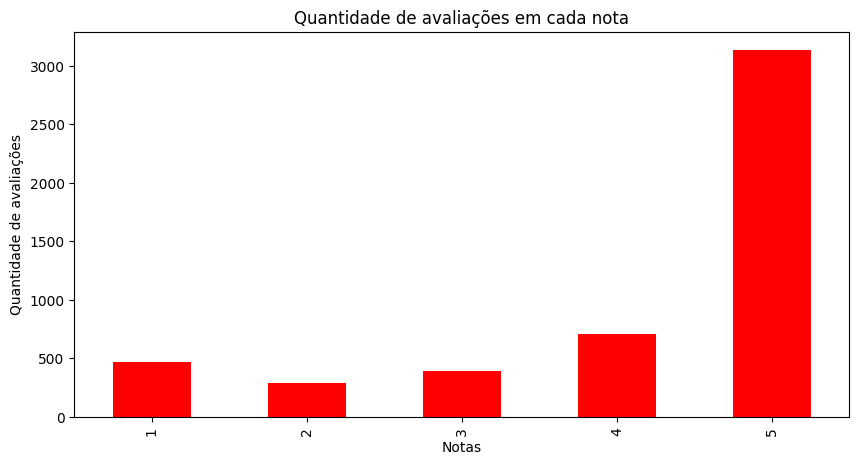

In [5]:
# Overview of reviews
print(df['Score'].value_counts().sort_index())

# Data visualization
graph = df['Score'].value_counts().sort_index().plot(kind='bar', title='Quantidade de avaliações em cada nota', figsize=(10, 5), color='red')
graph.set_xlabel('Notas')
graph.set_ylabel('Quantidade de avaliações')
graph.plot()

- Text labeling

    The classification of each review will be given according to the "Score".

    Neutral reviews will be ignored

        Score > 3: Positive

        Score < 3: Negative

        Score = 3: Neutral

[]

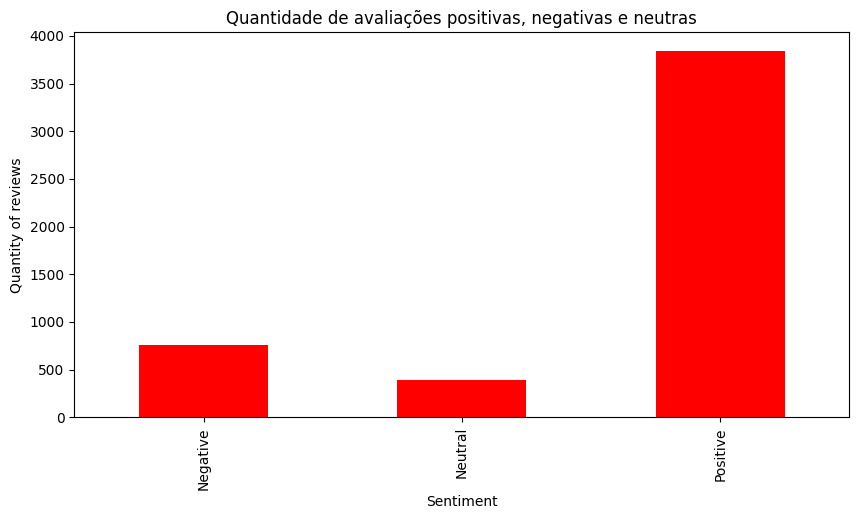

In [6]:
df['Sentiment'] = df['Score'].apply(lambda score: 'Positive' if score > 3 else ('Negative' if score < 3 else 'Neutral'))

# plot comparative graph
graph = df['Sentiment'].value_counts().sort_index().plot(kind='bar', title='Quantidade de avaliações positivas, negativas e neutras', figsize=(10, 5), color='red')
graph.set_xlabel('Sentiment')
graph.set_ylabel('Quantity of reviews')
graph.plot()

### Step 1. Data cleaning

Stopwords, HTML Tags, special characters and punctuation will be removed. The texts will be transformed into lowercase.

Stopwords are words that don't bring meaning to our sentence, like "I, are, all, mine, yours, ours, theirs, was...".

Normalization of similar words using "stemming". Stemming is the technique for removing suffixes and prefixes.

        Ex: Watch, Watched, Watching

- Check duplicates

In [7]:
# check dupicates and remove them
def remove_duplicates(df):
    df.drop_duplicates(subset = ['ProductId', 'ProfileName', 'Text'], keep = 'first', inplace = True)
    return df

df = remove_duplicates(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           4993 non-null   int64 
 1   ProductId    4993 non-null   object
 2   ProfileName  4993 non-null   object
 3   Score        4993 non-null   int64 
 4   Text         4993 non-null   object
 5   Sentiment    4993 non-null   object
dtypes: int64(2), object(4)
memory usage: 273.1+ KB


- Remove HTML Tags

In [8]:
def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

df.Text = df.Text.apply(remove_tags)
df.Text[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

- Remove special characters (punctuation)

In [9]:
def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

df.Text = df.Text.apply(remove_special_characters)
df.Text[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality The product looks more like a stew than a processed meat and it smells better My Labrador is finicky and she appreciates this product better than  most'

- Reviews to lowercase

In [10]:
def lower_case(text):
    return text.lower()

df.Text = df.Text.apply(lower_case)
df.Text[0]

'i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than  most'

- Remove stopwords

In [11]:
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
   
    # Add specific words to the stop_words list if necessary
    stop_words.update(['rt'])
    
    words = word_tokenize(text)
    filtered_text = [word for word in words if word not in stop_words]
    
    return filtered_text

df.Text = df.Text.apply(remove_stopwords)

# transform list to string
df.Text = df.Text.apply(lambda x: ' '.join(x))
df.Text[0]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andre_Rodrigues\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andre_Rodrigues\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

- Data normalization with 'stemming' technique

In [12]:
def stemming_words(text):
    stemmer = SnowballStemmer('english')
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

df.Text = df.Text.apply(stemming_words)

# transform list to string
df.Text = df.Text.apply(lambda x: ' '.join(x))
df.Text[0]

'bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better'

- Check frequent words in the dataset

        It can help us to insert new words into Stopwords list to be excluded from our analysis

In [13]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [14]:
# check 20 most common words
top_words = get_top_n_words(df.Text, n=20)

In [15]:
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Frequence"]
top_df

,Word,Frequence
0,like,2286
1,tast,2082
2,flavor,1823
3,good,1778
4,product,1555
5,use,1504
6,love,1501
7,one,1482
8,great,1441
9,tri,1436


### Step 2. Bag of words

Create the Bag of Words, which consists of a set of words that exist in our Dataset. Each word will only appear 1x in the BOW.

We will perform the tokenization of our dataset. Tokenization consists of transforming a string into a list of words called tokens. Tokens can consist of words, emoticons, hashtags, links, or even individual characters. A basic way to tokenize words is to split text based on whitespace and punctuation.

The NLTK library provides a default tokenizer with the word_tokenize(text) method

With the words tokenized, we will put a representation of each in our "bag of words".

In [16]:
# Simple BOW with 1 representation of each word
def generate_bow(sentences):
    words = CountVectorizer().fit(sentences)
    # remove duplicates
    words = list(set(words.get_feature_names()))
    return words

# Words and it's frequency BOW
def generate_bow_freq(sentences):
    vec = CountVectorizer().fit(sentences)
    bag_of_words = vec.transform(sentences)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[0:]

# Matrix BOW
def generate_bow_matrix(sentences):
    vec = CountVectorizer().fit(sentences)
    bag_of_words = vec.transform(sentences)
    return bag_of_words
    

### Step 3. Balanced Dataset

The dataset that will be used to train the model must be balanced with the same amount of samples for pos and neg groups

In [17]:
# verify how many positive and negative reviews we have
df.Sentiment.value_counts()

Positive    3842
Negative     756
Neutral      395
Name: Sentiment, dtype: int64

In [18]:
# 3842 pos, 756 neh, 395 neu
# We take 395 samples of each feeling type to form the balanced dataset
df_balanced = df.groupby('Sentiment').head(395)
df_balanced.Sentiment.value_counts()

Positive    395
Negative    395
Neutral     395
Name: Sentiment, dtype: int64

In [19]:
df_balanced.head()

,Id,ProductId,ProfileName,Score,Text,Sentiment
0,1,B001E4KFG0,delmartian,5,bought sever vital can dog food product found ...,Positive
1,2,B00813GRG4,dll pa,1,product arriv label jumbo salt peanutsth peanu...,Negative
2,3,B000LQOCH0,"Natalia Corres ""Natalia Corres""",4,confect around centuri light pillowi citrus ge...,Positive
3,4,B000UA0QIQ,Karl,2,look secret ingredi robitussin believ found go...,Negative
4,5,B006K2ZZ7K,"Michael D. Bigham ""M. Wassir""",5,great taffi great price wide assort yummi taff...,Positive


### Step 4. Training, validation and testing datasets

In [20]:
# Separate training(70%), validation(10%) and testing(20%) datasets
df_train, df_test = train_test_split(df_balanced, test_size=0.2, random_state=42)
df_train, df_validation = train_test_split(df_train, test_size=0.1, random_state=42)

### Step 5. Classification models

We will use the models for classification below

#### K-NN

KNN (K Nearest Neighbors) is a classification algorithm. KNN tries to predict the correct class for the test data by calculating the distance between the test data and all the training points. Then select the K number of points which is closet to the test data. The KNN algorithm calculates the probability of the test data belonging to the classes of ‘K’ training data and class holds the highest probability will be selected.

In [21]:
cv = CountVectorizer()

# K-nn sentiment analysis model
def generate_knn_model(d_train, vectorizer_array, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(vectorizer_array, d_train.Sentiment)

    return knn

def knn_sentiment_analysis(df, vectorizer_array, model):
    df_copy = df.copy()

    df_copy['knn_predicted'] = model.predict(vectorizer_array)
    df_copy['knn_accuracy'] = accuracy_score(df_copy.Sentiment, df_copy.knn_predicted)
    df_copy['knn_precision'] = precision_score(df_copy.Sentiment, df_copy.knn_predicted, average='macro')
    df_copy['knn_recall'] = recall_score(df_copy.Sentiment, df_copy.knn_predicted, average='macro')
    df_copy['knn_f1'] = f1_score(df_copy.Sentiment, df_copy.knn_predicted, average='macro')

    return df_copy

- K-nn model

In [22]:
knn_model = generate_knn_model(df_train, cv.fit_transform(df_train.Text), 5)

- Training model

In [23]:
df_train_knn = knn_sentiment_analysis(df_train, cv.transform(df_train.Text), knn_model)

print("\nQuantity of positive and negative values in the dataset:")
print(df_train.Sentiment.value_counts())

print("\nQuantity of positive and negative values found by the model:")
print(df_train_knn.knn_predicted.value_counts())

df_train_knn.head()


Quantity of positive and negative values in the dataset:
Negative    288
Positive    286
Neutral     279
Name: Sentiment, dtype: int64

Quantity of positive and negative values found by the model:
Negative    558
Positive    173
Neutral     122
Name: knn_predicted, dtype: int64


,Id,ProductId,ProfileName,Score,Text,Sentiment,knn_predicted,knn_accuracy,knn_precision,knn_recall,knn_f1
287,288,B001UJEN6C,Joseph Kagan,5,fantast product wish readili avail store tast ...,Positive,Positive,0.568581,0.665322,0.56582,0.552583
1895,1896,B001RVFDOO,"Sandy P ""saprater""",3,purchas hope healthi altern chip well theyr fa...,Neutral,Negative,0.568581,0.665322,0.56582,0.552583
175,176,B0025VRCJY,"Dario Quinonez ""aprilkid""",5,one best lemon juic tri recur custom due high ...,Positive,Positive,0.568581,0.665322,0.56582,0.552583
723,724,B000G6MBX2,HM,2,like potato chip hot sweet overwhelm tast garl...,Negative,Negative,0.568581,0.665322,0.56582,0.552583
357,358,B001SB099M,Thomas A. Johnson,4,great stuff depend especi million brand choos ...,Positive,Positive,0.568581,0.665322,0.56582,0.552583


- Validation model

In [24]:
df_validation_knn = knn_sentiment_analysis(df_validation, cv.transform(df_validation.Text), knn_model)

print("\nQuantity of positive and negative values in the dataset:")
print(df_validation.Sentiment.value_counts())

print("\nQuantity of positive and negative values found by the model:")
print(df_validation_knn.knn_predicted.value_counts())

df_validation_knn.head()


Quantity of positive and negative values in the dataset:
Negative    37
Neutral     32
Positive    26
Name: Sentiment, dtype: int64

Quantity of positive and negative values found by the model:
Negative    64
Positive    17
Neutral     14
Name: knn_predicted, dtype: int64


,Id,ProductId,ProfileName,Score,Text,Sentiment,knn_predicted,knn_accuracy,knn_precision,knn_recall,knn_f1
715,716,B000G6MBX2,J,2,guess there tell tickl palat im huge tabasco f...,Negative,Negative,0.431579,0.454744,0.412119,0.398109
1917,1918,B0016PKA1C,Barbara J. Conine,1,despit read review other hard open confid knew...,Negative,Negative,0.431579,0.454744,0.412119,0.398109
3151,3152,B000FDKQCY,"Leo G. McNeilly ""Leo G. McNeilly""",3,bit disappoint flavor want expect,Neutral,Negative,0.431579,0.454744,0.412119,0.398109
311,312,B003YDP5PA,"DF ""Dinky""",1,packag came label torn cook instruct know norm...,Negative,Negative,0.431579,0.454744,0.412119,0.398109
2795,2796,B000J2DQ46,jwyres,3,finish first bowl clam chowder disappoint find...,Neutral,Negative,0.431579,0.454744,0.412119,0.398109


- Testing model

In [25]:
df_test_knn = knn_sentiment_analysis(df_test, cv.transform(df_test.Text), knn_model)

print("\nQuantity of positive and negative values in the dataset:")
print(df_test.Sentiment.value_counts())

print("\nQuantity of positive and negative values found by the model:")
print(df_test_knn.knn_predicted.value_counts())

df_test_knn.head()


Quantity of positive and negative values in the dataset:
Neutral     84
Positive    83
Negative    70
Name: Sentiment, dtype: int64

Quantity of positive and negative values found by the model:
Negative    175
Positive     39
Neutral      23
Name: knn_predicted, dtype: int64


,Id,ProductId,ProfileName,Score,Text,Sentiment,knn_predicted,knn_accuracy,knn_precision,knn_recall,knn_f1
319,320,B001FB69YY,dewalt66,5,use frequent like asian dish least week love p...,Positive,Negative,0.409283,0.488589,0.435227,0.369157
2482,2483,B002JX7GVM,"Michael D. Briggs ""Dark_Psion""",2,receiv singl 85 contain one coconut water spla...,Negative,Negative,0.409283,0.488589,0.435227,0.369157
4962,4963,B001DW2RGO,Steele,3,six hour power help creat energet alert state ...,Neutral,Negative,0.409283,0.488589,0.435227,0.369157
86,87,B0019CW0HE,Ash52,5,dog ton allergi environment food prescript dog...,Positive,Positive,0.409283,0.488589,0.435227,0.369157
2632,2633,B0016FY6H6,skyebluepink,3,look altern green white ice tea powder realiz ...,Neutral,Negative,0.409283,0.488589,0.435227,0.369157


#### Vader model

Valence Aware Dictionary and sEntiment Reasoner (VADER) is an open source Python library built for use in sentiment analysis tasks.

Vader works in a very simple way: it has a collection of words, where each word already has a note (or feeling) assigned, and when passed a document (phrase) it returns the following values ​​in percentage:

        pos: how positive is that sentence/document;

        neu: how neutral is the sentence/document;

        neg: how much is negative;

compound: is the metric used to indicate the final conclusion regarding the sentence as a whole. It is calculated by adding the valence scores of each word in the lexicon, which generates a number between -1 (very negative) and +1 (very positive).

        If compound >= 0.05 -> Positive

        If compound <= -0.05 -> Negative

        If compounding between -0.04 and 0.04 -> Neutral

The compound is the most important metric when you just want to know if that sentence is positive or negative, because its value can be converted into those respective categories and that's exactly what we're going to learn to do here!

In [26]:
nltk.download('vader_lexicon')

def vader_sentiment_analysis(df):
    df_copy = df.copy()

    vader = SentimentIntensityAnalyzer()
    df_copy['vader_predicted'] = df_copy.Text.apply(lambda x: vader.polarity_scores(x)['compound'])

    df_copy['vader_predicted'] = df_copy.vader_predicted.apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

    df_copy['vader_accuracy'] = accuracy_score(df_copy.Sentiment, df_copy.vader_predicted)
    df_copy['vader_precision'] = precision_score(df_copy.Sentiment, df_copy.vader_predicted, average='macro')
    df_copy['vader_recall'] = recall_score(df_copy.Sentiment, df_copy.vader_predicted, average='macro')
    df_copy['vader_f1'] = f1_score(df_copy.Sentiment, df_copy.vader_predicted, average='macro')

    return df_copy
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Andre_Rodrigues\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


- Training model

In [27]:
df_train_vader = vader_sentiment_analysis(df_train)

print("\nQuantity of positive and negative values in the dataset:")
print(df_train.Sentiment.value_counts())

print("\nQuantity of positive and negative values found by the model:")
print(df_train_vader.vader_predicted.value_counts())

df_train_vader.head()


Quantity of positive and negative values in the dataset:
Negative    288
Positive    286
Neutral     279
Name: Sentiment, dtype: int64

Quantity of positive and negative values found by the model:
Positive    662
Negative    127
Neutral      64
Name: vader_predicted, dtype: int64


,Id,ProductId,ProfileName,Score,Text,Sentiment,vader_predicted,vader_accuracy,vader_precision,vader_recall,vader_f1
287,288,B001UJEN6C,Joseph Kagan,5,fantast product wish readili avail store tast ...,Positive,Positive,0.410317,0.426832,0.407866,0.338342
1895,1896,B001RVFDOO,"Sandy P ""saprater""",3,purchas hope healthi altern chip well theyr fa...,Neutral,Positive,0.410317,0.426832,0.407866,0.338342
175,176,B0025VRCJY,"Dario Quinonez ""aprilkid""",5,one best lemon juic tri recur custom due high ...,Positive,Positive,0.410317,0.426832,0.407866,0.338342
723,724,B000G6MBX2,HM,2,like potato chip hot sweet overwhelm tast garl...,Negative,Positive,0.410317,0.426832,0.407866,0.338342
357,358,B001SB099M,Thomas A. Johnson,4,great stuff depend especi million brand choos ...,Positive,Positive,0.410317,0.426832,0.407866,0.338342


- Validation model

In [28]:
df_validation_vader = vader_sentiment_analysis(df_validation)

print("\nQuantity of positive and negative values in the dataset:")
print(df_validation.Sentiment.value_counts())

print("\nQuantity of positive and negative values found by the model:")
print(df_validation_vader.vader_predicted.value_counts())

df_validation_vader.head()


Quantity of positive and negative values in the dataset:
Negative    37
Neutral     32
Positive    26
Name: Sentiment, dtype: int64

Quantity of positive and negative values found by the model:
Positive    73
Negative    17
Neutral      5
Name: vader_predicted, dtype: int64


,Id,ProductId,ProfileName,Score,Text,Sentiment,vader_predicted,vader_accuracy,vader_precision,vader_recall,vader_f1
715,716,B000G6MBX2,J,2,guess there tell tickl palat im huge tabasco f...,Negative,Positive,0.421053,0.502391,0.458463,0.36488
1917,1918,B0016PKA1C,Barbara J. Conine,1,despit read review other hard open confid knew...,Negative,Negative,0.421053,0.502391,0.458463,0.36488
3151,3152,B000FDKQCY,"Leo G. McNeilly ""Leo G. McNeilly""",3,bit disappoint flavor want expect,Neutral,Negative,0.421053,0.502391,0.458463,0.36488
311,312,B003YDP5PA,"DF ""Dinky""",1,packag came label torn cook instruct know norm...,Negative,Negative,0.421053,0.502391,0.458463,0.36488
2795,2796,B000J2DQ46,jwyres,3,finish first bowl clam chowder disappoint find...,Neutral,Positive,0.421053,0.502391,0.458463,0.36488


- Testing model

In [29]:
df_test_vader = vader_sentiment_analysis(df_test)

print("\nQuantity of positive and negative values in the dataset:")
print(df_test.Sentiment.value_counts())

print("\nQuantity of positive and negative values found by the model:")
print(df_test_vader.vader_predicted.value_counts())

df_test_vader.head()


Quantity of positive and negative values in the dataset:
Neutral     84
Positive    83
Negative    70
Name: Sentiment, dtype: int64

Quantity of positive and negative values found by the model:
Positive    185
Negative     37
Neutral      15
Name: vader_predicted, dtype: int64


,Id,ProductId,ProfileName,Score,Text,Sentiment,vader_predicted,vader_accuracy,vader_precision,vader_recall,vader_f1
319,320,B001FB69YY,dewalt66,5,use frequent like asian dish least week love p...,Positive,Positive,0.447257,0.492492,0.441777,0.375752
2482,2483,B002JX7GVM,"Michael D. Briggs ""Dark_Psion""",2,receiv singl 85 contain one coconut water spla...,Negative,Positive,0.447257,0.492492,0.441777,0.375752
4962,4963,B001DW2RGO,Steele,3,six hour power help creat energet alert state ...,Neutral,Positive,0.447257,0.492492,0.441777,0.375752
86,87,B0019CW0HE,Ash52,5,dog ton allergi environment food prescript dog...,Positive,Positive,0.447257,0.492492,0.441777,0.375752
2632,2633,B0016FY6H6,skyebluepink,3,look altern green white ice tea powder realiz ...,Neutral,Positive,0.447257,0.492492,0.441777,0.375752


#### Logistic Regression model

It is a probabilistic prediction model that seeks to predict a binary value of 0 or 1, which is more malleable and can be used in complex classification cases. In the formula of this method, outliers are not considered, since they are only considered data close to a line that divides the data according to the specified attributes. Like the Perceptron algorithm, it is an algorithm that requires a lot of training and can only find a linear separator for the data if the data are linearly separable.

In [30]:

def logistic_regression_model(df_train, vectorizer_array, max_iter=1000):
    lr = LogisticRegression(max_iter=max_iter)
    lr.fit(vectorizer_array, df_train.Sentiment)

    return lr

def logistic_regression_sentiment_analysis(df, vectorizer_array, model):
    df_copy = df.copy()

    df_copy['lr_predicted'] = model.predict(vectorizer_array)
    df_copy['lr_accuracy'] = accuracy_score(df_copy.Sentiment, df_copy.lr_predicted)
    df_copy['lr_precision'] = precision_score(df_copy.Sentiment, df_copy.lr_predicted, average='macro')
    df_copy['lr_recall'] = recall_score(df_copy.Sentiment, df_copy.lr_predicted, average='macro')
    df_copy['lr_f1'] = f1_score(df_copy.Sentiment, df_copy.lr_predicted, average='macro')

    return df_copy

- Create model

In [31]:
lr_model = logistic_regression_model(df_train, cv.fit_transform(df_train.Text))

- Train model

In [32]:
df_train_logistic_regression = logistic_regression_sentiment_analysis(df_train, cv.transform(df_train.Text), lr_model)

print("\nQuantity of positive and negative values in the dataset:")
print(df_train.Sentiment.value_counts())

print("\nQuantity of positive and negative values found by the model:")
print(df_train_logistic_regression.lr_predicted.value_counts())

df_train_logistic_regression.head()


Quantity of positive and negative values in the dataset:
Negative    288
Positive    286
Neutral     279
Name: Sentiment, dtype: int64

Quantity of positive and negative values found by the model:
Negative    288
Positive    286
Neutral     279
Name: lr_predicted, dtype: int64


,Id,ProductId,ProfileName,Score,Text,Sentiment,lr_predicted,lr_accuracy,lr_precision,lr_recall,lr_f1
287,288,B001UJEN6C,Joseph Kagan,5,fantast product wish readili avail store tast ...,Positive,Positive,1.0,1.0,1.0,1.0
1895,1896,B001RVFDOO,"Sandy P ""saprater""",3,purchas hope healthi altern chip well theyr fa...,Neutral,Neutral,1.0,1.0,1.0,1.0
175,176,B0025VRCJY,"Dario Quinonez ""aprilkid""",5,one best lemon juic tri recur custom due high ...,Positive,Positive,1.0,1.0,1.0,1.0
723,724,B000G6MBX2,HM,2,like potato chip hot sweet overwhelm tast garl...,Negative,Negative,1.0,1.0,1.0,1.0
357,358,B001SB099M,Thomas A. Johnson,4,great stuff depend especi million brand choos ...,Positive,Positive,1.0,1.0,1.0,1.0


- Validation model

In [33]:
df_validation_logistic_regression = logistic_regression_sentiment_analysis(df_validation, cv.transform(df_validation.Text), lr_model)

print("\nQuantity of positive and negative values in the dataset:")
print(df_validation.Sentiment.value_counts())

print("\nQuantity of positive and negative values found by the model:")
print(df_validation_logistic_regression.lr_predicted.value_counts())

df_validation_logistic_regression.head()


Quantity of positive and negative values in the dataset:
Negative    37
Neutral     32
Positive    26
Name: Sentiment, dtype: int64

Quantity of positive and negative values found by the model:
Negative    38
Neutral     34
Positive    23
Name: lr_predicted, dtype: int64


,Id,ProductId,ProfileName,Score,Text,Sentiment,lr_predicted,lr_accuracy,lr_precision,lr_recall,lr_f1
715,716,B000G6MBX2,J,2,guess there tell tickl palat im huge tabasco f...,Negative,Negative,0.694737,0.702562,0.691355,0.695807
1917,1918,B0016PKA1C,Barbara J. Conine,1,despit read review other hard open confid knew...,Negative,Negative,0.694737,0.702562,0.691355,0.695807
3151,3152,B000FDKQCY,"Leo G. McNeilly ""Leo G. McNeilly""",3,bit disappoint flavor want expect,Neutral,Negative,0.694737,0.702562,0.691355,0.695807
311,312,B003YDP5PA,"DF ""Dinky""",1,packag came label torn cook instruct know norm...,Negative,Negative,0.694737,0.702562,0.691355,0.695807
2795,2796,B000J2DQ46,jwyres,3,finish first bowl clam chowder disappoint find...,Neutral,Neutral,0.694737,0.702562,0.691355,0.695807


- Testing model

In [34]:
df_test_logistic_regression = logistic_regression_sentiment_analysis(df_test, cv.transform(df_test.Text), lr_model)

print("\nQuantity of positive and negative values in the dataset:")
print(df_test.Sentiment.value_counts())

print("\nQuantity of positive and negative values found by the model:")
print(df_test_logistic_regression.lr_predicted.value_counts())

df_test_logistic_regression.head()


Quantity of positive and negative values in the dataset:
Neutral     84
Positive    83
Negative    70
Name: Sentiment, dtype: int64

Quantity of positive and negative values found by the model:
Positive    83
Negative    81
Neutral     73
Name: lr_predicted, dtype: int64


,Id,ProductId,ProfileName,Score,Text,Sentiment,lr_predicted,lr_accuracy,lr_precision,lr_recall,lr_f1
319,320,B001FB69YY,dewalt66,5,use frequent like asian dish least week love p...,Positive,Positive,0.620253,0.617831,0.62117,0.617584
2482,2483,B002JX7GVM,"Michael D. Briggs ""Dark_Psion""",2,receiv singl 85 contain one coconut water spla...,Negative,Negative,0.620253,0.617831,0.62117,0.617584
4962,4963,B001DW2RGO,Steele,3,six hour power help creat energet alert state ...,Neutral,Positive,0.620253,0.617831,0.62117,0.617584
86,87,B0019CW0HE,Ash52,5,dog ton allergi environment food prescript dog...,Positive,Negative,0.620253,0.617831,0.62117,0.617584
2632,2633,B0016FY6H6,skyebluepink,3,look altern green white ice tea powder realiz ...,Neutral,Negative,0.620253,0.617831,0.62117,0.617584


### Comparison of results

#### Accuracy

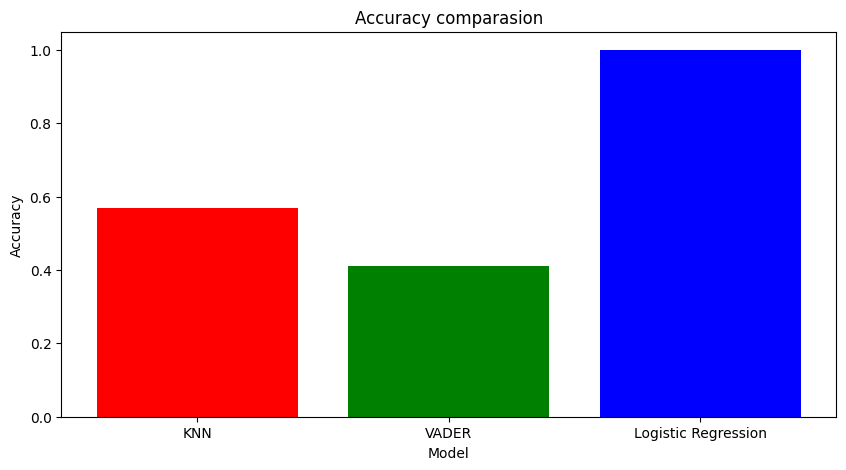

In [35]:
def plot_accuracy_comparasion(df_knn, df_vader, logistic_regression_df):
    plt.figure(figsize=(10, 5))
    plt.bar(['KNN', 'VADER', 'Logistic Regression'], [df_knn.knn_accuracy.mean(), df_vader.vader_accuracy.mean(), logistic_regression_df.lr_accuracy.mean()], color=['red', 'green', 'blue'])
    plt.title('Accuracy comparasion')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.show()

plot_accuracy_comparasion(df_train_knn, df_train_vader, df_train_logistic_regression)

#### Precision

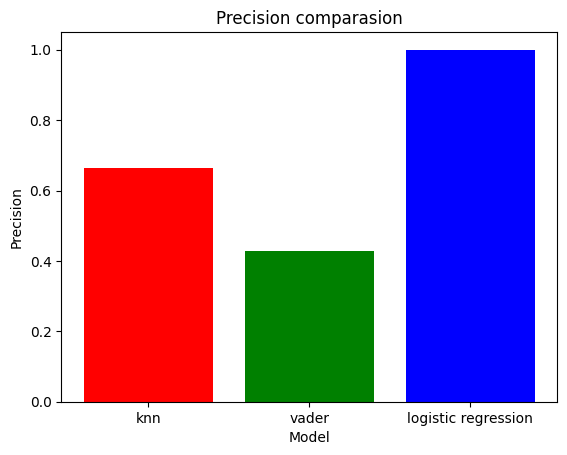

In [36]:
def plot_precision_comparasion(df_knn, df_vader, logistic_regression_df):
    x = ['knn', 'vader', 'logistic regression']
    y = [df_knn.knn_precision.mean(), df_vader.vader_precision.mean(), logistic_regression_df.lr_precision.mean()]

    plt.bar(x, y, color=['red', 'green', 'blue'])
    plt.title('Precision comparasion')
    plt.xlabel('Model')
    plt.ylabel('Precision')
    plt.show()

plot_precision_comparasion(df_train_knn, df_train_vader, df_train_logistic_regression)

#### Recall

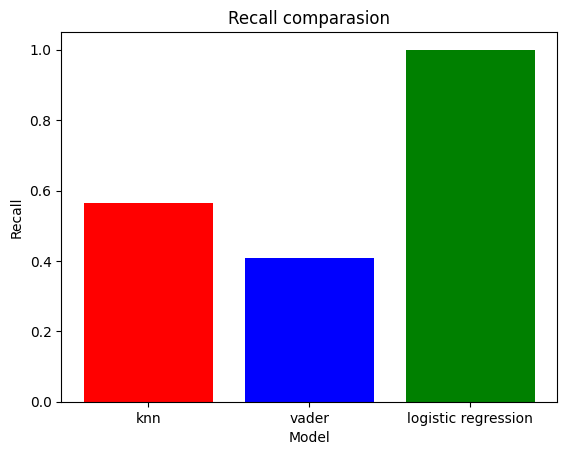

In [37]:
def plot_recall_comparasion(df_knn, df_vader, logistic_regression_df):
    x = ['knn', 'vader', 'logistic regression']
    y = [df_knn.knn_recall.mean(), df_vader.vader_recall.mean(), logistic_regression_df.lr_recall.mean()]

    plt.bar(x, y, color=['red', 'blue', 'green'])
    plt.title('Recall comparasion')
    plt.xlabel('Model')
    plt.ylabel('Recall')
    plt.show()

plot_recall_comparasion(df_train_knn, df_train_vader, df_train_logistic_regression)

#### F-Measure

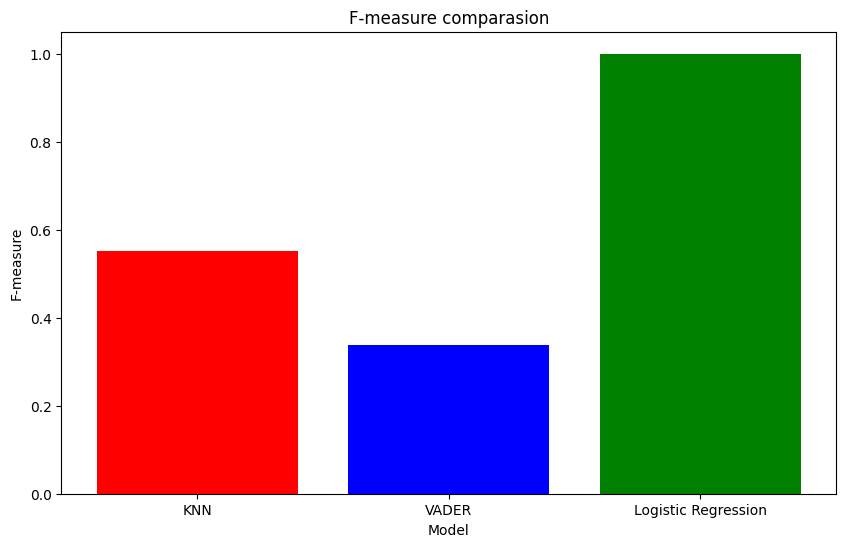

In [38]:
def plot_fmeasure_comparasion(knn_df, vader_df, logistic_regression_df):
    plt.figure(figsize=(10, 6))

    plt.bar('KNN', knn_df.knn_f1.mean(), color='red')
    plt.bar('VADER', vader_df.vader_f1.mean(), color='blue')
    plt.bar('Logistic Regression', logistic_regression_df.lr_f1.mean(), color='green')

    plt.title('F-measure comparasion')
    plt.xlabel('Model')
    plt.ylabel('F-measure')

    plt.show()

plot_fmeasure_comparasion(df_train_knn, df_train_vader, df_train_logistic_regression)